In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Arabic.txt to Arabic (1).txt
Saving Chinese.txt to Chinese (1).txt
Saving Czech.txt to Czech (1).txt
Saving Dutch.txt to Dutch (1).txt
Saving English.txt to English (1).txt
Saving French.txt to French (1).txt
Saving German.txt to German (1).txt
Saving Greek.txt to Greek (1).txt
Saving Irish.txt to Irish (1).txt
Saving Italian.txt to Italian (1).txt
Saving Japanese.txt to Japanese (1).txt
Saving Korean.txt to Korean (1).txt
Saving Polish.txt to Polish (1).txt
Saving Portuguese.txt to Portuguese (1).txt
Saving Russian.txt to Russian (1).txt
Saving Scottish.txt to Scottish (1).txt
Saving Spanish.txt to Spanish (1).txt
Saving Vietnamese.txt to Vietnamese (1).txt


In [ ]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['German.txt', 'Portuguese (1).txt', 'English.txt', 'Irish.txt', 'French.txt', 'Vietnamese (1).txt', 'French (1).txt', 'Russian (1).txt', 'Korean (1).txt', 'Polish (1).txt', 'German (1).txt', 'Spanish (1).txt', 'Spanish.txt', 'Dutch.txt', 'Chinese.txt', 'Polish.txt', 'Russian.txt', 'Scottish (1).txt', 'Greek.txt', 'Scottish.txt', 'Greek (1).txt', 'Czech.txt', 'Dutch (1).txt', 'English (1).txt', 'Japanese (1).txt', 'Portuguese.txt', 'Chinese (1).txt', 'Irish (1).txt', 'Arabic (1).txt', 'Italian.txt', 'Czech (1).txt', 'Vietnamese.txt', 'Italian (1).txt', 'Japanese.txt', 'Korean.txt', 'Arabic.txt']
Slusarski


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
category_lines['English'][:5]

['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']

In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)

        # The linear layer that maps from hidden state space to output space
        self.h2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # LSTM layer, output shape: [batch_size, seq_len, num_directions * hidden_size]
        lstm_out, hidden = self.lstm(input, hidden)

        # Since lstm_out is [1, 1, hidden_size], we reshape it to [1, hidden_size]
        # We take the output of the last time step
        lstm_out = lstm_out.view(-1, self.hidden_size)

        # Pass the reshaped output through the linear layer and softmax
        output = self.h2o(lstm_out)
        output = self.softmax(output)
        return output, hidden


        # # Note: we run this all at once (over the whole input sequence)
        # output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        # output = self.h2o(output.view(1, -1))
        # output = self.softmax(output)
        # return output, hidden

    def initHidden(self):
        # Initialize hidden and cell states
        # Note: the 1st argument is the number of layers, the 2nd is the batch size, and the 3rd is the hidden_size
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # The linear layer that maps from hidden state space to output space
        # Make sure the input dimension matches the hidden size of the LSTM
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # LSTM layer, output shape: [batch_size, seq_len, num_directions * hidden_size]
        output, hidden = self.lstm(input, hidden)

        # Reshape or slice the output for the linear layer
        output = output[:, -1, :]  # Taking the output of the last time step
        output = self.h2o(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # Initialize hidden (h_0) and cell (c_0) states
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

IndexError: ignored

In [ ]:
# Assuming lineToTensor('Albert') returns a tensor of shape [len('Albert'), n_letters]
input = lineToTensor('Albert')
hidden = lstm.initHidden()

input_reshaped = input[0].view(1, 1, -1)  # Reshape to [1, 1, input_size]
output, next_hidden = lstm(input_reshaped, hidden)

# Processing the first character
output, next_hidden = lstm(input_reshaped, hidden)
print(output)

tensor([[-3.6461, -3.5332, -3.6688, -3.5097, -3.5448, -3.5059, -3.6081, -3.5499,
         -3.5818, -3.6769, -3.6234, -3.6633, -3.6453, -3.5453, -3.5848, -3.5681,
         -3.5234, -3.6492, -3.5918, -3.6634, -3.6376, -3.5228, -3.5435, -3.5401,
         -3.6326, -3.5632, -3.5465, -3.4889, -3.5592, -3.5624, -3.6875, -3.5743,
         -3.5676, -3.5065, -3.5842, -3.6629]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
output.shape, output

(torch.Size([1, 36]),
 tensor([[-3.6461, -3.5332, -3.6688, -3.5097, -3.5448, -3.5059, -3.6081, -3.5499,
          -3.5818, -3.6769, -3.6234, -3.6633, -3.6453, -3.5453, -3.5848, -3.5681,
          -3.5234, -3.6492, -3.5918, -3.6634, -3.6376, -3.5228, -3.5435, -3.5401,
          -3.6326, -3.5632, -3.5465, -3.4889, -3.5592, -3.5624, -3.6875, -3.5743,
          -3.5676, -3.5065, -3.5842, -3.6629]], grad_fn=<LogSoftmaxBackward0>))

In [ ]:
next_hidden

(tensor([[[-0.0192, -0.0117, -0.0275, -0.0084,  0.0011, -0.0067,  0.0181,
            0.0165, -0.0164,  0.0019, -0.0016,  0.0190, -0.0034, -0.0197,
           -0.0160,  0.0013,  0.0124, -0.0119, -0.0137, -0.0415, -0.0048,
           -0.0026,  0.0294,  0.0154, -0.0410, -0.0352, -0.0202, -0.0197,
            0.0084,  0.0397, -0.0228, -0.0103,  0.0255,  0.0022, -0.0424,
            0.0199, -0.0037,  0.0156,  0.0044,  0.0145, -0.0397,  0.0018,
            0.0060,  0.0112,  0.0267,  0.0235,  0.0093,  0.0217, -0.0458,
           -0.0104, -0.0135,  0.0118,  0.0155, -0.0036,  0.0070, -0.0391,
            0.0105,  0.0128, -0.0013,  0.0178, -0.0177, -0.0244, -0.0117,
            0.0174, -0.0132, -0.0078, -0.0015, -0.0124, -0.0354, -0.0272,
            0.0004,  0.0005, -0.0300,  0.0205,  0.0024, -0.0085,  0.0126,
            0.0095, -0.0355,  0.0191,  0.0105, -0.0114,  0.0184, -0.0214,
            0.0116, -0.0263, -0.0183,  0.0069,  0.0497,  0.0193,  0.0292,
           -0.0003,  0.0210, -0.0140, 

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish (1)', 27)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Pavlicka
category = Czech (1) / line = Kara
category = Chinese / line = Jian
category = Japanese (1) / line = Nakahara
category = Dutch (1) / line = Horn
category = French (1) / line = Mathieu
category = English (1) / line = Elmhirst
category = Greek (1) / line = Metrofanis
category = Scottish / line = Boyle
category = English (1) / line = Hiscocks


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    next_hidden = lstm.initHidden()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        # output, hidden = lstm(line_tensor[i], hidden)
        output, next_hidden = lstm(input_reshaped, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 23s) 3.6255 Gai / Irish (1) ✗ (Chinese)
10000 10% (0m 47s) 3.6161 Reiher / Russian ✗ (German (1))
15000 15% (1m 11s) 3.5187 Doan / Spanish ✗ (Vietnamese (1))
20000 20% (1m 35s) 3.5163 Pho / English (1) ✗ (Vietnamese (1))
25000 25% (1m 59s) 3.5833 Docherty / Arabic (1) ✗ (Scottish (1))
30000 30% (2m 24s) 3.6230 Santana / Arabic (1) ✗ (Portuguese (1))
35000 35% (2m 49s) 3.5924 Weldon / Czech ✗ (English)
40000 40% (3m 12s) 3.5943 Loyola / Spanish (1) ✗ (Spanish)
45000 45% (3m 36s) 3.5719 Lai / English ✗ (Chinese (1))
50000 50% (4m 0s) 3.6097 Bonner / Vietnamese (1) ✗ (French)
55000 55% (4m 23s) 3.6059 Bosko / Chinese ✗ (Polish)
60000 60% (4m 47s) 3.5486 Vasquez / Dutch ✗ (Spanish (1))
65000 65% (5m 11s) 3.5785 Malouf / Dutch ✗ (Arabic (1))
70000 70% (5m 34s) 3.5104 Klerks / Korean ✗ (Dutch)
75000 75% (5m 58s) 3.5311 Mohren / Russian ✗ (Dutch (1))
80000 80% (6m 24s) 3.5578 Han / Korean ✗ (Vietnamese (1))
85000 85% (6m 49s) 3.6144 Chastain / Italian (1) ✗ (French (1))
90000 90% 

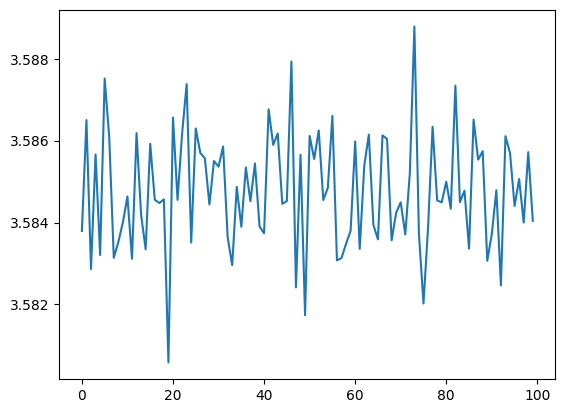

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Accuracy   : 0.0424


<ipython-input-75-5bef0a40208e>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-75-5bef0a40208e>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


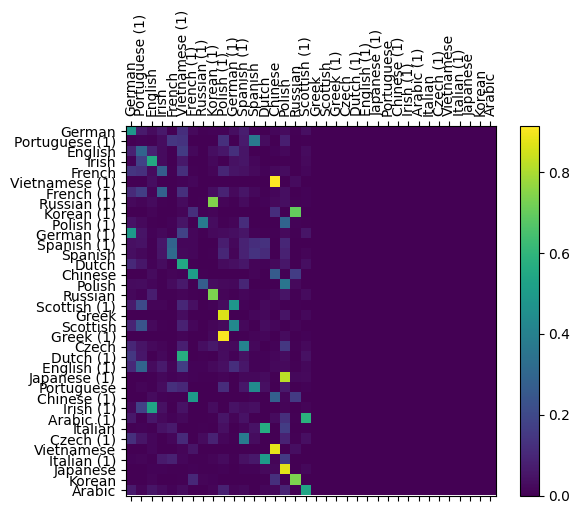

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

y_test=[]
y_pred=[]

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    y_test.append(category)
    y_pred.append(guess)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
confusion.diagonal()/confusion.sum(axis=1)

tensor([0.3962, 0.0106, 0.0531, 0.0516, 0.0000, 0.0118, 0.0000, 0.0072, 0.0034,
        0.0071, 0.0244, 0.0551, 0.1298, 0.0072, 0.3212, 0.3366, 0.0036, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
sum(confusion.diagonal()/confusion.sum(axis=1))

tensor(1.4190)

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.78) Korean (1)
(-0.83) Spanish (1)
(-2.80) Portuguese (1)

> Jackson
(-1.02) German (1)
(-1.43) Portuguese (1)
(-2.44) Irish

> Satoshi
(-0.67) Polish
(-1.81) Scottish (1)
(-2.42) Dutch
